In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pickle
import collections
import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt
import matplotlib
from lib.sparse_tools import dense_sparse_dot, dense_sparse_add
from tqdm import tqdm

In [20]:
matplotlib.rcParams.update({'font.size': 20})

---

Our datasets:

In [21]:
datasets_names = ("LSHTC1", "DMOZ", "WIKI_Small", "WIKI_50K", "WIKI_100K")
dataset_dir = "../data"
out_dir = "../data/parsed"

In [22]:
%%time

# Read the dataset.

# dataset_name = "WIKI_100K"
dataset_name = "LSHTC1"
# dataset_name = "DMOZ"

with open(os.path.join(out_dir, "%s_train.dump" % dataset_name), "rb") as fin:
    X_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_train_out.dump" % dataset_name), "rb") as fin:
    y_train = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout.dump" % dataset_name), "rb") as fin:
    X_test = pickle.load(fin)
with open(os.path.join(out_dir, "%s_heldout_out.dump" % dataset_name), "rb") as fin:
    y_test = pickle.load(fin)

CPU times: user 68.1 ms, sys: 216 ms, total: 284 ms
Wall time: 470 ms


---

#### Average IoU of classes (as bag-of-words of their documents):

In [105]:
classes_tokens = collections.defaultdict(set)

In [106]:
%%time

for a, b, y in tqdm(zip(X_train.indptr, X_train.indptr[1:], y_train)):
    classes_tokens[y] |= set(X_train.indices[a:b])

126871it [00:05, 25231.02it/s]

CPU times: user 4.49 s, sys: 453 ms, total: 4.94 s
Wall time: 5.03 s


In [ ]:
%%time

avg_iou_num = 0
avg_iou_den = 0

for y1, c1 in tqdm(classes_tokens.items()):
    for y2, c2 in classes_tokens.items():
        u = len(c1 | c2)
        if u > 0:
            iou = len(c1 & c2) / u
            avg_iou_num += iou
            avg_iou_den += 1

In [152]:
avg_iou_num/avg_iou_den

0.11863847316584965

---

Iris datasets:

In [ ]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [ ]:
iris_data = load_iris()
X, y = iris_data["data"], iris_data["target"]

In [ ]:
X = np.hstack([X, np.ones(X.shape[0]).reshape(-1, 1)])
X = ss.csr_matrix(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

---

In [112]:
%%time

X_train = ss.hstack([X_train, np.ones(X_train.shape[0]).reshape(-1, 1)])
X_test = ss.hstack([X_test, np.ones(X_test.shape[0]).reshape(-1, 1)])
X_train, X_test = ss.csr_matrix(X_train), ss.csr_matrix(X_test)

CPU times: user 2.82 s, sys: 3.12 s, total: 5.93 s
Wall time: 6.73 s


---

### M-SVM from liblinear

In [156]:
import liblinear

In [44]:
%time m = liblinear.train(y_train[:1000], X_train[:1000], "-s 4")

CPU times: user 1min 22s, sys: 4.15 s, total: 1min 27s
Wall time: 1min 33s


In [53]:
%time liblinear.save_model("msvm.mdl", m)

CPU times: user 55.8 s, sys: 2.5 s, total: 58.3 s
Wall time: 1min


---

In [27]:
from sklearn.metrics import pairwise_distances_argmin

In [14]:
np.random.seed(0)
index_ids = np.random.randint(X_train.shape[0], size=2000)
query_ids = np.random.randint(len(index_ids), size=100)

In [15]:
%%time

data = X_train[index_ids] #.toarray()
query = data[query_ids]

CPU times: user 8.32 ms, sys: 4.13 ms, total: 12.4 ms
Wall time: 11.2 ms


### nmslib for ANN

In [3]:
import nmslib

In [26]:
np.zeros((3,2), dtype=np.float32)

array([[0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [6]:
%%time

index = nmslib.init(method="sw-graph", space="cosinesimil_sparse",
                    data_type=nmslib.DataType.SPARSE_VECTOR)
#index.addDataPointBatch(ss.csr_matrix((100, 1000), dtype=np.float32), range(100))
#index.createIndex({'indexThreadQty': 4}, print_progress=False)
index.createIndex()

CPU times: user 461 µs, sys: 277 µs, total: 738 µs
Wall time: 605 µs


In [102]:
%%time

start_id = len(index)
index.addDataPointBatch(data, range(start_id, start_id + data.shape[0]))
index.createIndex({'indexThreadQty': 4}, print_progress=False)

CPU times: user 910 ms, sys: 6.66 ms, total: 917 ms
Wall time: 279 ms


In [103]:
%time index.saveIndex("index.dump")

CPU times: user 14.9 ms, sys: 13.2 ms, total: 28.1 ms
Wall time: 30.1 ms


In [36]:
%timeit nbrs = index.knnQueryBatch(query, k=1, num_threads=4)

16.6 ms ± 329 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
%time nbrs = index.knnQueryBatch(data, k=1, num_threads=4)

CPU times: user 4.17 s, sys: 13.5 ms, total: 4.18 s
Wall time: 1.19 s


In [18]:
%time nbrs = index.knnQueryBatch(X_train[228:328], k=1, num_threads=4)

CPU times: user 38.2 ms, sys: 1.56 ms, total: 39.8 ms
Wall time: 13.5 ms


In [43]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 100

18.82

In [44]:
sum([x[0][0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.941

---

### PySparNN for ANN

In [47]:
import pysparnn.cluster_index as ci

In [48]:
%%time

# build the search index!
data_to_return = list(range(X_train.shape[0]))
cp = ci.MultiClusterIndex(X_train, data_to_return, num_indexes=1)

CPU times: user 3min 22s, sys: 3.77 s, total: 3min 25s
Wall time: 3min 31s


In [51]:
%timeit nbrs = cp.search(data, k=1, return_distance=False)

4.19 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
sum([x[0] == y for x, y in zip(nbrs, index_ids)]) / 2000

0.981

---

In [114]:
"""
Vector in a form: a * v
"""
class WeightVector:
    # TODO: add squared norm

    def __init__(self, dimension):
        self.d = dimension
        self.a = 1.0
        self.v = np.zeros(self.d, dtype=np.float64)

    def sparse_dot(self, u: ss.csr_matrix):
        return dense_sparse_dot(self.v, u) * self.a

    def sparse_add(self, u: ss.csr_matrix, s: float):
        dense_sparse_add(self.v, u * (s / self.a), inplace=True)
    
    def add(self, other, s: float):
        self.v *= self.a
        self.v += other.v * other.a * s
        self.a = 1.0

    def scale(self, s: float):
        if abs(s) < 1e-9:
            self.__init__(self.d)
        else:
            self.a *= s
    
    def get_snorm(self):
        return (self.a ** 2) * np.dot(self.v, self.v)

In [122]:
def stochastic_pegasos(X: np.array, y: np.array, pos_class: int, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    labels = ((y == pos_class) * 2 - 1)

    # TODO: make parameters
    max_iter = 150000
    num_to_avg = 120000
    lambd = 0.0005
    k = 100

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    avg_scale = min(max_iter, num_to_avg)
    avg_wv = WeightVector(d)
    wv = WeightVector(d)
    wvs = []

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        eta = 1. / (lambd * (i + 2))
        grad_ixs, grad_weights = [], []
        for j in x_ids:
            x = X.getrow(j)
            pred = wv.sparse_dot(x)
            label = labels[j]
            if label * pred < 1:
                grad_ixs.append(j)
                grad_weights.append(eta * label / k)
        # Scale wv
        wv.scale(1. - eta * lambd)
        # Add sub-gradients
        for grad_ix, grad_w in zip(grad_ixs, grad_weights):
            wv.sparse_add(X.getrow(grad_ix), grad_w)
        # Projection step
        wv.scale(min(1., 1. / np.sqrt(lambd * wv.get_snorm())))
        # Average weights
        if i >= max_iter - num_to_avg:
            avg_wv.add(wv, 1. / avg_scale)
            if (i + 1) % 100 == 0:
                wvs.append(avg_wv.a * avg_wv.v)
        else:
            if (i + 1) % 100 == 0:
                wvs.append(wv.a * wv.v)
    
    return wvs

In [ ]:
def multi_pegasos(X: np.array, y: np.array, random_seed=None) -> List[np.ndarray]:    
    n, d = X.shape

    labels = ((y == pos_class) * 2 - 1)

    # TODO: make parameters
    max_iter = 150000
    num_to_avg = 120000
    lambd = 0.0005
    k = 100

    if random_seed is not None:
        np.random.seed(random_seed)
    random_ids = np.random.choice(n, size=max_iter * k)

    avg_scale = min(max_iter, num_to_avg)
    avg_wv = WeightVector(d)
    wv = WeightVector(d)
    wvs = []

    for i in tqdm(range(max_iter)):
        x_ids = random_ids[i * k : (i + 1) * k]
        eta = 1. / (lambd * (i + 2))
        grad_ixs, grad_weights = [], []
        for j in x_ids:
            x = X.getrow(j)
            pred = wv.sparse_dot(x)
            label = labels[j]
            if label * pred < 1:
                grad_ixs.append(j)
                grad_weights.append(eta * label / k)
        # Scale wv
        wv.scale(1. - eta * lambd)
        # Add sub-gradients
        for grad_ix, grad_w in zip(grad_ixs, grad_weights):
            wv.sparse_add(X.getrow(grad_ix), grad_w)
        # Projection step
        wv.scale(min(1., 1. / np.sqrt(lambd * wv.get_snorm())))
        # Average weights
        if i >= max_iter - num_to_avg:
            avg_wv.add(wv, 1. / avg_scale)
            if (i + 1) % 100 == 0:
                wvs.append(avg_wv.a * avg_wv.v)
        else:
            if (i + 1) % 100 == 0:
                wvs.append(wv.a * wv.v)
    
    return wvs

In [123]:
pos_class = 11

In [124]:
%time wvs = stochastic_pegasos(X_train, y_train, pos_class=pos_class, random_seed=0)

100%|██████████| 150000/150000 [2:49:54<00:00, 14.71it/s]

CPU times: user 20min 55s, sys: 1min 40s, total: 22min 35s
Wall time: 2h 49min 54s


---

**Оценка качества:**

In [125]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression

In [126]:
w_pegasos = wvs[-1].reshape(-1, 1)

In [127]:
w_pegasos.T

array([[ 0.02137611, -0.09405117,  0.02113176, ...,  0.        ,
        -0.51107077, -0.51107077]])

In [128]:
%%time

clf = LogisticRegression(C=1.0)
clf.fit(X_train, y_train == pos_class)
w_lr = clf.coef_.reshape(-1, 1)

CPU times: user 1min 40s, sys: 2.26 s, total: 1min 42s
Wall time: 1min 43s


In [129]:
y_true = (y_test == pos_class)
y_pred_pegasos = (X_test.dot(w_pegasos) > 0).T[0]
y_pred_lr = (X_test.dot(w_lr) > 0).T[0]

In [130]:
collections.Counter(y_pred_pegasos)

Counter({False: 34301, True: 205})

In [131]:
collections.Counter(y_pred_lr)

Counter({False: 34201, True: 305})

In [132]:
print(classification_report(y_true, y_pred_pegasos))

             precision    recall  f1-score   support

      False       0.99      1.00      1.00     34090
       True       0.71      0.35      0.47       416

avg / total       0.99      0.99      0.99     34506



In [133]:
print(classification_report(y_true, y_pred_lr))

             precision    recall  f1-score   support

      False       0.99      1.00      0.99     34090
       True       0.57      0.42      0.48       416

avg / total       0.99      0.99      0.99     34506



In [134]:
confusion_matrix(y_true, y_pred_pegasos)

array([[34031,    59],
       [  270,   146]])

In [135]:
confusion_matrix(y_true, y_pred_lr)

array([[33959,   131],
       [  242,   174]])

---

In [136]:
%%time

f1s_train = []
f1s_test = []

for w in tqdm(wvs):
    w = w.reshape(-1, 1)
    y_true = (y_train == pos_class)
    y_pred = (X_train.dot(w) > 0).T[0]
    f1s_train.append(f1_score(y_true, y_pred))
    y_true = (y_test == pos_class)
    y_pred = (X_test.dot(w) > 0).T[0]
    f1s_test.append(f1_score(y_true, y_pred))

100%|██████████| 1500/1500 [04:47<00:00,  5.21it/s]


CPU times: user 4min 34s, sys: 11.9 s, total: 4min 46s
Wall time: 4min 47s


In [140]:
y_train[y_train == 11].shape

(4757,)

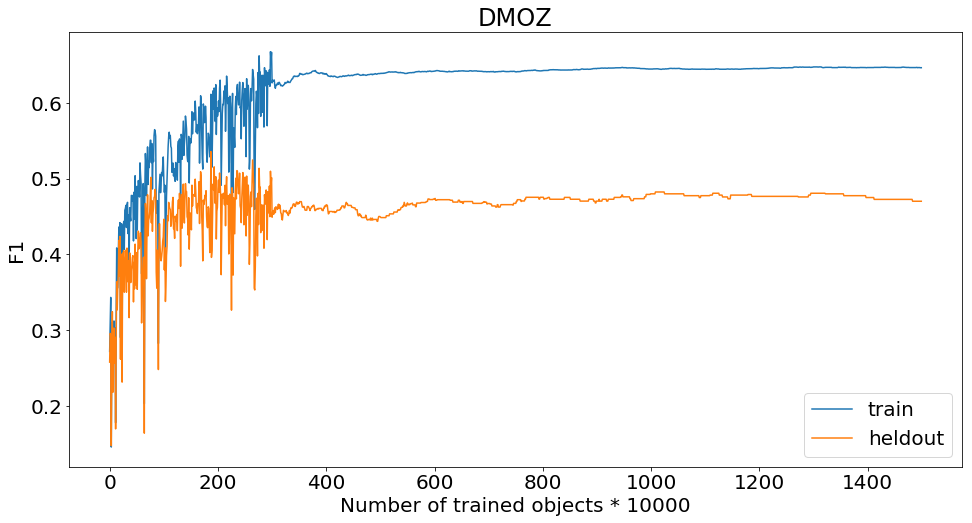

In [137]:
plt.figure(figsize=(16, 8))
plt.plot(range(len(f1s_train)), f1s_train)
plt.plot(range(len(f1s_test)), f1s_test)
plt.title("DMOZ")
plt.ylabel("F1")
plt.xlabel("Number of trained objects * 10000")
plt.legend(["train", "heldout"], loc="lower right")
plt.savefig("DMOZ_binary.eps", bbox_inches="tight")
plt.savefig("DMOZ_binary.png", bbox_inches="tight", dpi=300)

---